In [1]:
!pip install torchmetrics

In [2]:
!pip install torchsummary

In [3]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
from torchsummary import summary

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
!pwd

/kaggle/working


In [5]:
# Set the working (writable) directory.
working_dir = "/kaggle/working/currentWorking/"

In [6]:
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join(working_dir, cp_name))


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
    # end while
# end def

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [7]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|██████████| 791918971/791918971 [00:25<00:00, 31449049.43it/s]


Extracting /kaggle/working/currentWorking/OxfordPets/train/oxford-iiit-pet/images.tar.gz to /kaggle/working/currentWorking/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16223199.34it/s]


Extracting /kaggle/working/currentWorking/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/currentWorking/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:41<00:00, 19203179.56it/s]


Extracting /kaggle/working/currentWorking/OxfordPets/test/oxford-iiit-pet/images.tar.gz to /kaggle/working/currentWorking/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 14189543.19it/s]


Extracting /kaggle/working/currentWorking/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/currentWorking/OxfordPets/test/oxford-iiit-pet


In [8]:
pets_train_orig, pets_test_orig

(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: /kaggle/working/currentWorking/OxfordPets/train,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: /kaggle/working/currentWorking/OxfordPets/test)

In [9]:
(train_pets_input, train_pets_target) = pets_train_orig[20]

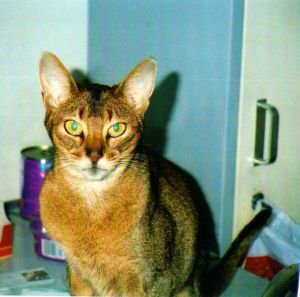

In [10]:
# Spot check an input image.
train_pets_input

In [11]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

In [12]:
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

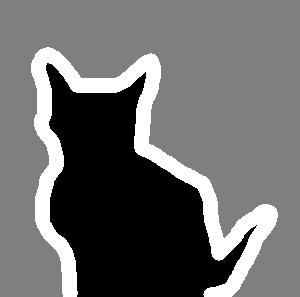

In [13]:
# Spot check a segmentation mask image after post-processing it
# via trimap2f().
target_tensor = trimap2f(train_pets_target)
t2img(target_tensor)

In [14]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [15]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [16]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

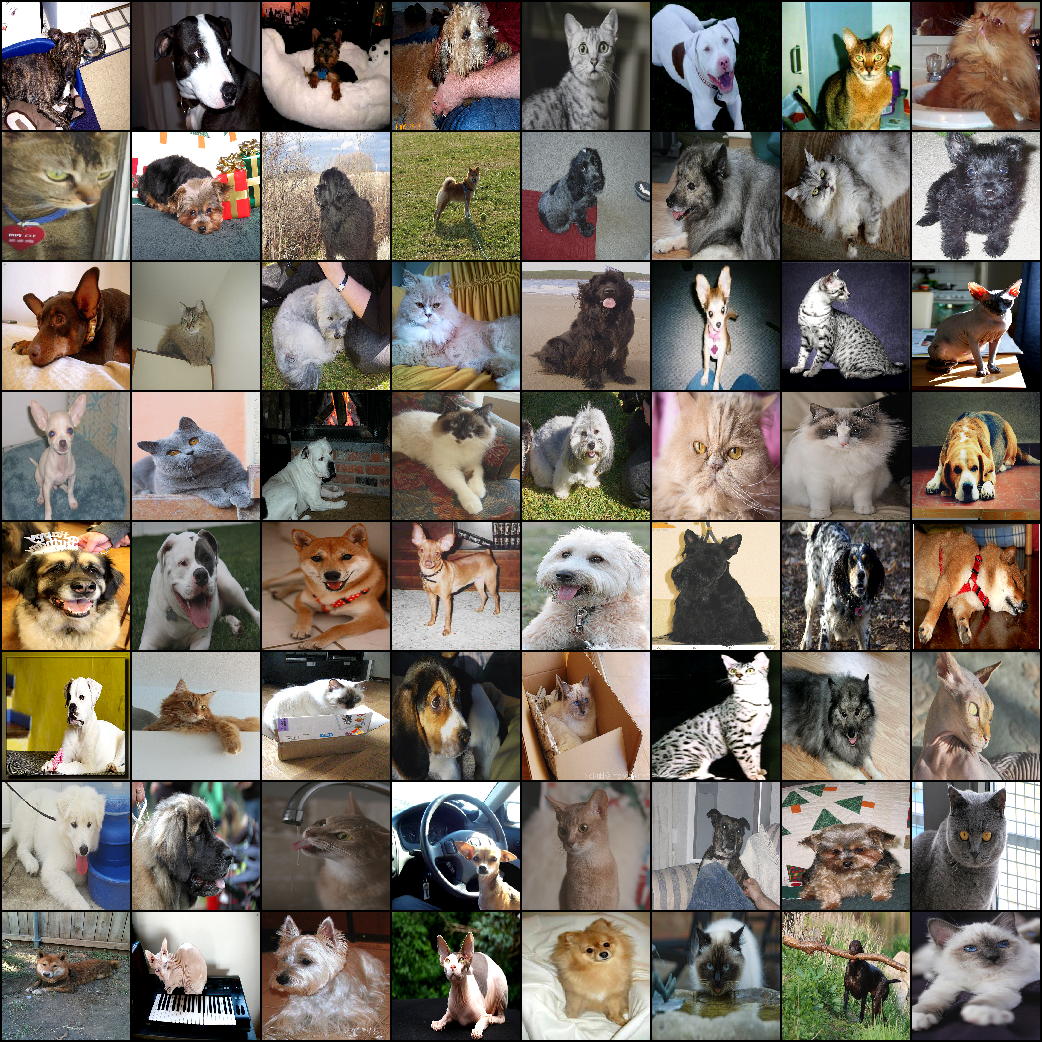

In [17]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

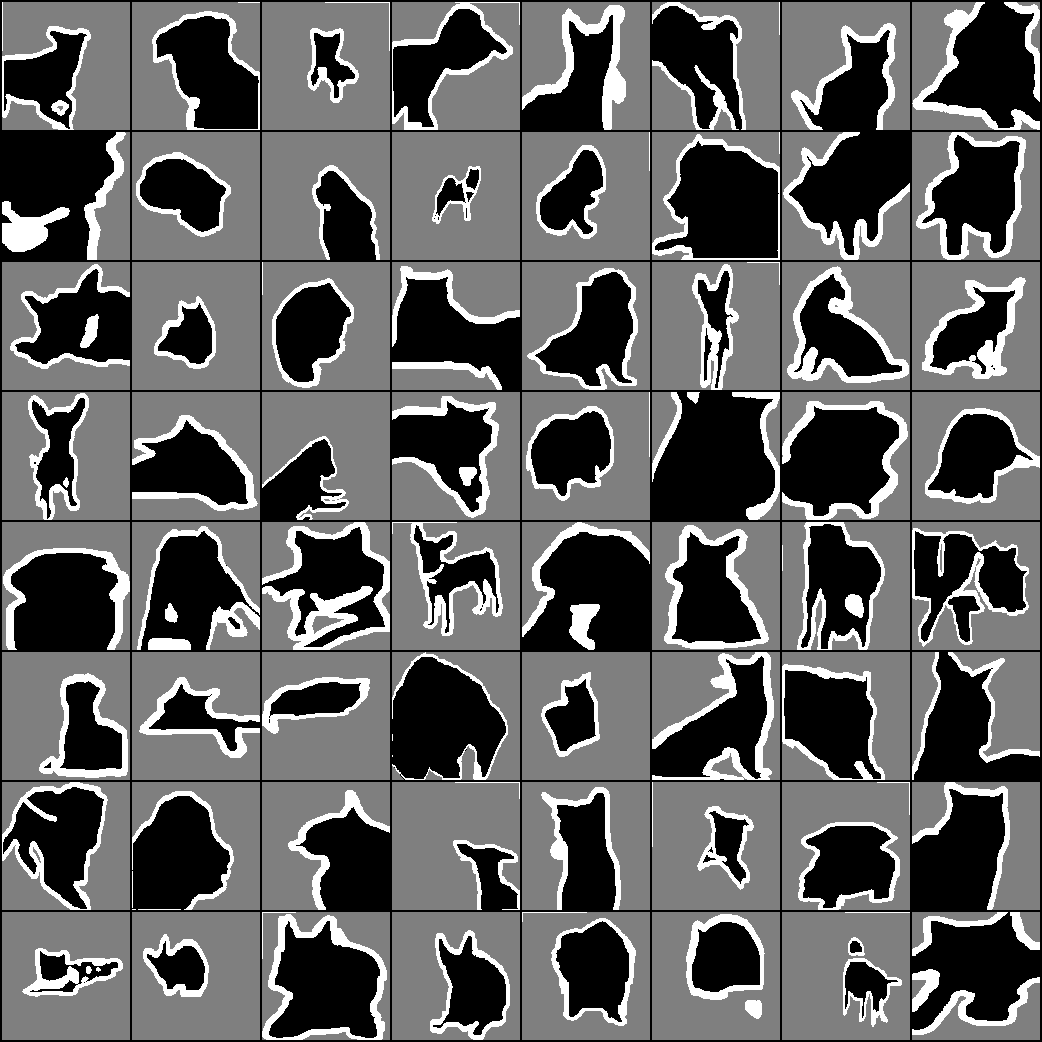

In [18]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

In [19]:
#                  N  C  H
# The printed row is the W dimension.
train_pets_targets[3][0]

tensor([[1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 1, 1, 2],
        [1, 1, 1,  ..., 1, 1, 2],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')

In [20]:
class DownConv2(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        
    def forward(self, x):
        y = self.seq(x)
        return y


class DownConv3(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
    def forward(self, x):
        y = self.seq(x)
        return y

In [21]:
class UpConv2(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, padding=1,stride=2,output_padding=1, bias=False),
            
        )
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        
    def forward(self, x1, x2):
        x = self.up(x1)
        y = self.conv(torch.cat([x,x2], dim=1))
        return y
    
class UpConv3(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=in_ch, kernel_size=kernel_size, padding=1,stride=2,output_padding=1, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, padding=1,stride=2,output_padding=1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        
    def forward(self, x):
        y = self.seq(x)
        return y

In [22]:
class ImageSegUnet(nn.Module):
    def __init__(self, kernel_size, n_class):
        super().__init__()
        self.dc1 = DownConv2(3, 64, kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size)
        self.dc3 = DownConv2(128, 256, kernel_size)
        self.dc4 = DownConv2(256, 512, kernel_size)
        
        self.up1 = UpConv2(512, 256, kernel_size)
        self.up2 = UpConv2(256, 128, kernel_size)
        self.up3 = UpConv2(128, 64, kernel_size)
        #self.up4 = UpConv2(64, 1, kernel_size)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.softmax = nn.Softmax(dim=1)
        
        self.out_conv = nn.Conv2d(64, n_class, kernel_size=1, stride=1)
        
    def forward(self, x):
        #print('Input shape:',x.shape)
        x1 = self.dc1(x)
        #print('First down conv:',x1.shape)
        x1mp = self.max_pool(x1)
        x2 = self.dc2(x1mp)
        #print('2nd down conv:',x2.shape)
        x2mp = self.max_pool(x2)
        x3 = self.dc3(x2mp)
        #print('3rd down conv:',x3.shape)
        x3mp = self.max_pool(x3)
        x4 = self.dc4(x3mp)
        #print('4th down conv:',x4.shape)
        x5 = self.up1(x4,x3)
        #print('First up conv:',x5.shape)
        x6 = self.up2(x5, x2)
        #print('2nd up conv:',x6.shape)
        x = self.up3(x6, x1)
        #print('3rd up conv:',x.shape)
        x = self.out_conv(x)
        x = self.softmax(x)
        #x = self.up4(x)
        #x = self.softmax(x)
        #x = self.up1(x)
        #x = self.up2(x)
        #x = self.up3(x)
        #x = self.up4(x)
        #x = self.softmax(x)
        return x

In [23]:
model = ImageSegUnet(kernel_size=3, n_class=3)
model = to_device(model)

In [24]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         DownConv2-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,728
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,456
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

In [25]:
#IOU metric
def IoUMetric(pred, gt):
    gt = torch.cat([(gt==i) for i in range(3)], dim=1)
    intersection = pred * gt
    union = gt + pred - intersection
    
    
    iou = (intersection.sum(dim=(1,2,3))+0.001)/(union.sum(dim=(1,2,3))+0.001)
    
    return iou.mean()

def IOULoss(pred, gt):
    return -(IoUMetric(pred, gt).log())

In [26]:
x = torch.rand((2, 3, 2, 2), requires_grad=True)
x = nn.Softmax(dim=1)(x)
y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)

In [27]:
z = IOULoss(x,y)

In [28]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()

def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if

    if show_plot is False:
        close_figures()
    else:
        plt.show()

In [29]:
model = to_device(model)
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)


In [30]:
for i in range(1, 21):
    print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
    to_device(model.train())
    running_loss = 0.0
    running_samples = 0
    for batch_idx, (inputs, targets) in enumerate(pets_train_loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)
        loss = IOULoss(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_samples += targets.size(0)
        running_loss += loss.item()
        
    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))
    
    if scheduler is not None:
            scheduler.step()

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7342
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4362
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.3688
Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.3350
Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.3174
Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.2978
Epoch: 07, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.2833
Epoch: 08, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.2646
Epoch: 09, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.2553
Epoch: 10, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.2470
Epoch: 11, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.2455
Epoch: 12, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.2393
Epoch: 13, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.2345
Epoch: 14, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.2324
Epoch: 15, Learning Rate: 0.00049
Trained 3680 samples,

In [31]:
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))

In [32]:
to_device(model.eval())

(test_pets_inputs, test_pets_targets)

predictions = model(to_device(test_pets_inputs))
test_pets_targets = to_device(test_pets_targets)


In [33]:
pred_labels = predictions.argmax(dim=1)
pred_labels = pred_labels.unsqueeze(1)

In [34]:
print(predictions.shape)
print(pred_labels.shape)

torch.Size([21, 3, 128, 128])
torch.Size([21, 1, 128, 128])


In [35]:
def plot_test_predictions(test_pets_inputs, test_pets_targets, pred_labels):
    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_inputs, nrow=7)))
    plt.axis('off')
    plt.title("Input")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_labels / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

Accuracy[Pixel: 0.8570, IoU: 0.6865, Custom IoU: 0.7766]
Accuracy[Pixel: 0.8707, IoU: 0.7482, Custom IoU: 0.7847]
Accuracy[Pixel: 0.8909, IoU: 0.7475, Custom IoU: 0.8074]
Accuracy[Pixel: 0.9041, IoU: 0.7610, Custom IoU: 0.8269]
Accuracy[Pixel: 0.8940, IoU: 0.7514, Custom IoU: 0.8177]
Accuracy[Pixel: 0.8717, IoU: 0.7322, Custom IoU: 0.7783]
Accuracy[Pixel: 0.8787, IoU: 0.7189, Custom IoU: 0.7897]
Accuracy[Pixel: 0.8886, IoU: 0.7388, Custom IoU: 0.8012]
Accuracy[Pixel: 0.8877, IoU: 0.7314, Custom IoU: 0.8007]
Accuracy[Pixel: 0.9039, IoU: 0.7454, Custom IoU: 0.8277]
Accuracy[Pixel: 0.8916, IoU: 0.7389, Custom IoU: 0.8092]
Accuracy[Pixel: 0.9102, IoU: 0.7640, Custom IoU: 0.8404]
Accuracy[Pixel: 0.8973, IoU: 0.7542, Custom IoU: 0.8180]
Accuracy[Pixel: 0.9105, IoU: 0.7400, Custom IoU: 0.8395]
Accuracy[Pixel: 0.9061, IoU: 0.7355, Custom IoU: 0.8331]
Accuracy[Pixel: 0.8709, IoU: 0.6702, Custom IoU: 0.7804]
Accuracy[Pixel: 0.8884, IoU: 0.7585, Custom IoU: 0.8034]
Accuracy[Pixel: 0.8951, IoU: 0.

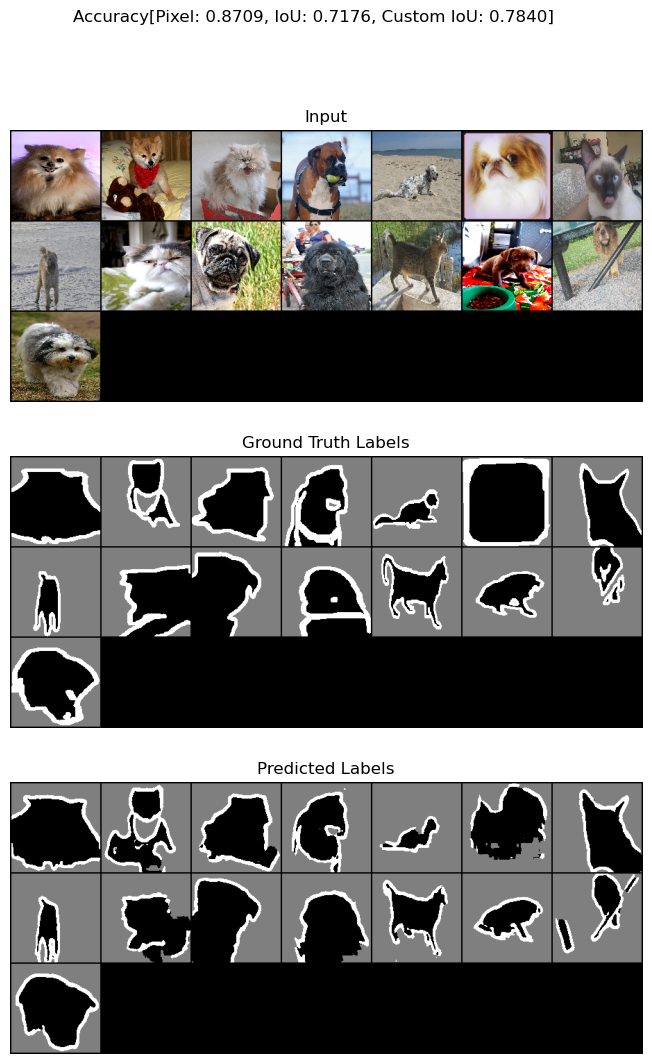

In [36]:
to_device(model.eval())
for batch_idx, (inputs, test_pets_targets) in enumerate(pets_test_loader, 0):
    inputs = to_device(inputs)
    test_pets_targets = to_device(test_pets_targets)
    predictions = model(inputs)
    pred_labels = predictions.argmax(dim=1)
    pred_labels = pred_labels.unsqueeze(1)
    
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_labels, test_pets_targets)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_targets)
    custom_iou = IoUMetric(predictions, test_pets_targets)
    title = f'Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    
    print(title)
    plot_test_predictions(inputs, test_pets_targets, pred_labels)